# Bank of England Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from matplotlib.ticker import FuncFormatter
from scipy.stats import linregress
import requests
import io
from pathlib import Path

In [2]:
def get_data(
    name: str,
    codes: str,
    start_date: str,
    end_date: str = "",
) -> pd.DataFrame:
    """Return DataFrame with requested BoE data."""
    today = date.today()
    filename = name + "_" + today.strftime("%Y%m%d") + ".pkl"

    if Path(filename).is_file():  # already fetched
        return pd.read_pickle(filename)

    url_endpoint = (
        "http://www.bankofengland.co.uk/boeapps/iadb/fromshowcolumns.asp?csv.x=yes"
    )

    if end_date == "":
        end_date = today.strftime("%d/%b/%Y")

    payload = {
        "Datefrom": start_date,
        "Dateto": end_date,
        "SeriesCodes": codes,
        "CSVF": "TN",
        "UsingCodes": "Y",
        "VPD": "Y",
        "VFD": "N",
    }

    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/54.0.2840.90 "
        "Safari/537.36"
    }

    response = requests.get(url_endpoint, params=payload, headers=headers)
    print(response.status_code)
    # print(response.url)
    # print(response.content)
    df_boe = pd.read_csv(io.BytesIO(response.content))
    df_boe["DATE"] = pd.to_datetime(df_boe["DATE"], format="%d %b %Y")
    df_boe.to_pickle(filename)
    return df_boe

## Mortgages

In [3]:
df = get_data("mortgages", "LPMB3C2,LPMVTVU", "01/Jan/2000")
df.columns = ["Date", "Total", "Number"]
df["Average"] = df["Total"] / df["Number"] * 1000000
df = df.sort_values(by="Date")
df["Month_Year"] = df["Date"].dt.strftime("%b %y")
last_date = df["Date"].max().strftime("%d %b %y")
df

,Date,Total,Number,Average,Month_Year
0,2000-01-31,2859,50816,56261.807305,Jan 00
1,2000-02-29,4605,87861,52412.333117,Feb 00
2,2000-03-31,6176,118265,52221.705492,Mar 00
3,2000-04-30,5132,99600,51526.104418,Apr 00
4,2000-05-31,5748,110890,51835.151952,May 00
...,...,...,...,...,...
293,2024-06-30,15571,66625,233711.069418,Jun 24
294,2024-07-31,17148,73174,234345.532566,Jul 24
295,2024-08-31,15748,66939,235258.967119,Aug 24
296,2024-09-30,15289,65048,235041.815275,Sep 24


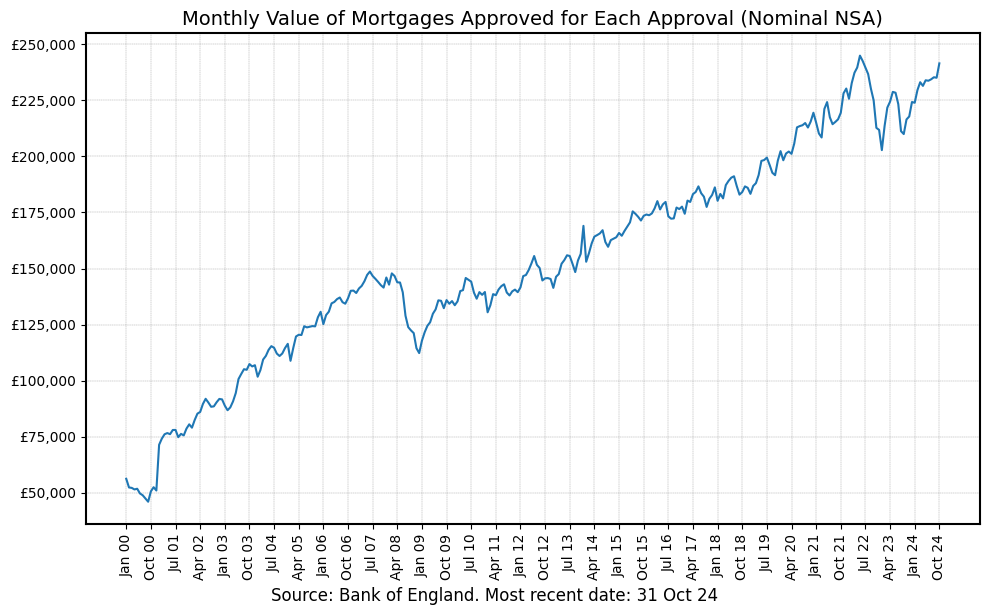

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_facecolor("white")

ax.plot(df["Month_Year"], df["Average"])

ax.set_title(
    "Monthly Value of Mortgages Approved for Each Approval (Nominal NSA)", fontsize=14
)

formatter = FuncFormatter(lambda x, pos: f"£{x:,.0f}")
plt.gca().yaxis.set_major_formatter(formatter)
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)

xticks = df["Month_Year"][::9]  # every nth date
plt.xticks(xticks, rotation=90)

for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.5,
    -0.01,
    f"Source: Bank of England. Most recent date: {last_date}",
    ha="center",
    fontsize=12,
    color="black",
)

plt.tight_layout()

plt.savefig("mortgages.png", dpi=300, bbox_inches="tight")

## Savings

In [5]:
df = get_data("savings", "LPMB8S4,LPMVYWO,LPMZOD3,LPMZOD4,LPMZOD5", "01/Jan/2010")
names = ["ISA", "Cash", "No_Interest", "Interest", "Time"]
df.columns = ["Date"] + names
df["Total"] = df[names].sum(axis=1)  # * 1000000
df = df.sort_values(by="Date")
df["Month_Year"] = df["Date"].dt.strftime("%b %y")
last_date = df["Date"].max().strftime("%d %b %y")
df

,Date,ISA,Cash,No_Interest,Interest,Time,Total,Month_Year
0,2010-01-31,165446,45714,66165,435060,250267,962652,Jan 10
1,2010-02-28,165496,45416,69772,438745,252077,971506,Feb 10
2,2010-03-31,167499,46018,70542,442046,253778,979883,Mar 10
3,2010-04-30,172780,46387,70633,441821,253651,985272,Apr 10
4,2010-05-31,173664,47161,70651,440260,252818,984554,May 10
...,...,...,...,...,...,...,...,...
173,2024-06-30,370003,78746,232499,884780,248963,1814991,Jun 24
174,2024-07-31,372997,78691,227445,883163,248780,1811076,Jul 24
175,2024-08-31,376028,78689,230637,889826,248499,1823679,Aug 24
176,2024-09-30,379150,78660,230701,894045,248940,1831496,Sep 24


In [6]:
# Add pre-covid linear regression
start_date = "2010-01-01"
end_date = "2020-03-01"

# Filter data for the regression fit
fit_data = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]

# Convert dates to numeric format for regression (e.g., as days since the first date)
df["days"] = (df["Date"] - df["Date"].min()).dt.days
fit_data = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)].copy()

# Fit linear regression
# slope, intercept, _, _, _ = linregress(fit_data['days'], fit_data['Total'])
slope, intercept, rvalue, _, _ = linregress(fit_data["days"], fit_data["Total"])

# Calculate R-squared
precovid_r_squared = rvalue**2

# Project regression line over the full date range
df["pre-covid"] = intercept + slope * df["days"]

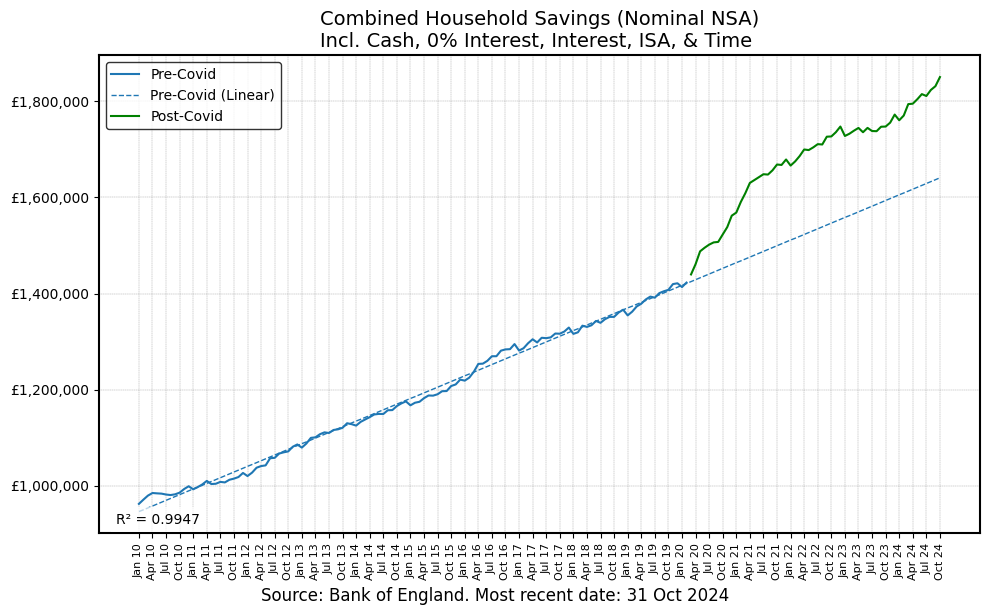

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor("white")

# Split the data into two parts based on the date
df_precovid = df[df["Date"] <= end_date]
df_postcovid = df[df["Date"] > end_date]

# Pre-covid
(line1,) = ax.plot(df_precovid["Month_Year"], df_precovid["Total"], label="Pre-Covid")
color = line1.get_color()

ax.plot(
    df["Month_Year"],
    df["pre-covid"],
    label="Pre-Covid (Linear)",
    color=color,
    linestyle="--",
    linewidth=1,
)

# Post-covid
ax.plot(
    df_postcovid["Month_Year"], df_postcovid["Total"], color="green", label="Post-Covid"
)


ax.set_title(
    "Combined Household Savings (Nominal NSA)\nIncl. Cash, 0% Interest, Interest, ISA, & Time ",
    fontsize=14,
)

formatter = FuncFormatter(lambda x, pos: f"£{x:,.0f}")
plt.gca().yaxis.set_major_formatter(formatter)
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)

xticks = df["Month_Year"][::3]  # every nth date
plt.xticks(xticks, rotation=90)
plt.tick_params(axis="x", labelsize=8)

# Set the spines (borders) to black
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.5,
    -0.01,
    "Source: Bank of England. Most recent date: 31 Oct 2024",
    ha="center",
    fontsize=12,
    color="black",
)

# Add R-squared as a note in the bottom-left corner
plt.text(
    0.02,
    0.02,  # Position: 2% from the bottom-left
    f"R² = {precovid_r_squared:.4f}",
    transform=plt.gca().transAxes,  # (0,0 is bottom-left)
    fontsize=10,  # Font size
    color="black",  # Text color
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
)

plt.legend(facecolor="white", edgecolor="black", fontsize=10)
plt.tight_layout()

plt.savefig("savings.png", dpi=300, bbox_inches="tight")